In [ ]:
% matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import os
import sys
import random
from glob import glob

from multiprocessing import Pool
import numpy as np
import pandas as pd

from tqdm import tqdm
import scipy.misc
import skimage.measure

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# Definitions

In [88]:
# Set some parameters
IMG_CHANNELS = 3
DATA = {
    'TRAIN': '/home/wellbeier/cdata/kaggle-dsbowl-2018-dataset-fixes/stage1_train/',
    'TEST': '/home/wellbeier/cdata/test/',
    'AUGMENTED': '/home/wellbeier/cdata/augmented/',
    'PREPARED': '/home/wellbeier/cdata/prepared/'
}

train_paths = glob(os.path.join(DATA['TRAIN'], '*'))
test_paths = glob(os.path.join(DATA['TEST'], '*'))

MASK_POSTFIX = 'mask_ibn'
seed = 42
P_THRESHOLD = .5
BATCH_SIZE = 16
SIDE = 256
STEP = SIDE // 4

# Amount of categories predicted per pixels.
nb_classes = 1

np.random.seed = seed

SPLIT = .9

# Annotation

In [ ]:
ccomponents = dict()
for n, path in tqdm(enumerate(train_paths), total=len(train_paths)):
    masks = list()
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        masks.append(scipy.misc.imread(path + '/masks/' + mask_file) > 0)

    mask = np.zeros(shape=(len(masks) + 2,) + masks[-1].shape)
    mask[2:] = np.stack(masks)
    mask[0], colours = scipy.ndimage.label(mask[2:].max(0))

    ccs = dict()
    for colour in range(1, colours + 1):
        im = mask[0] == colour
        ccs[colour] = ((mask[2:] * im).max((1, 2)).sum())
        mask[1, im] = ccs[colour]

    ccomponents[os.path.basename(path)] = ccs
    np.save(path + '/augmentation_labels', mask)

In [ ]:
import pickle

pickle.dump(ccomponents, open('/home/wellbeier/cdata/meta/ccomponents.pkl', 'wb'))

In [ ]:
image_types = dict()
images = dict()
mask_types = dict()
i = 0

while i < len(train_paths):
    clear_output()

    plt.figure(figsize=(17, 7))
    for j, (n, el) in enumerate(images.items()):
        plt.subplot(max(np.ceil(len(images) / 4), 1), 4, j + 1)
        plt.imshow(el)
        plt.axis('off')
    plt.show()

    
    print("Iteration %d/%d" % (i, len(train_paths)))
    img = scipy.misc.imread(
        os.path.join(
            train_paths[i], 
            'images', 
            os.path.basename(train_paths[i]) + '.png'
        )
    )[..., :IMG_CHANNELS]

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    token = input()
    if token == 'back':
        i -= 1
        continue
    image_types[os.path.basename(train_paths[i])] = token
    images[token] = img

    contours = list()
    for mask_file in next(os.walk(train_paths[i] + '/masks/'))[2]:
        masks = scipy.misc.imread(train_paths[i] + '/masks/' + mask_file) > 0
        contours.extend(skimage.measure.find_contours(masks, 0.8))
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    for n, contour in enumerate(contours):
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    plt.axis('off')
    plt.show()

    token = input()
    mask_types[os.path.basename(train_paths[i])] = token
    
    i += 1

In [ ]:
import pickle

pickle.dump(image_types, open('/home/wellbeier/cdata/meta/image_types.pkl', 'wb'))
pickle.dump(mask_types, open('/home/wellbeier/cdata/meta/mask_types.pkl', 'wb'))

# Augmentation

In [69]:
from collections import defaultdict
import pickle

image_types = pickle.load(open('/home/wellbeier/cdata/meta/image_types.pkl', 'rb'))
mask_types = pickle.load(open('/home/wellbeier/cdata/meta/mask_types.pkl', 'rb'))

types = np.unique(list(image_types.values()))
type_dict = defaultdict(list)
for pid, type_id in image_types.items():
    type_dict[type_id].append(pid)

ids = [os.path.basename(path) for path in train_paths]

for key in type_dict.keys():
    type_dict[key] = [pid for pid in type_dict[key] if pid in ids]

In [70]:
type_dict['3']

['8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760fb92ae23ab4',
 '091944f1d2611c916b98c020bd066667e33f4639159b2a92407fe5a40788856d',
 '76a372bfd3fad3ea30cb163b560e52607a8281f5b042484c3a0fc6d0aa5a7450',
 '8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa',
 '1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e',
 '2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812',
 '4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40',
 '1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df',
 '3594684b9ea0e16196f498815508f8d364d55fea2933a2e782122b6f00375d04',
 '7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770',
 '54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12',
 '5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e',
 '08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992',
 '4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381',
 '5e263abff938acba1c0cff698261c7c0

In [138]:
instances = dict()
for key in type_dict.keys():
    print(key, len(type_dict[key]))
    instances[key] = 200 if len(type_dict[key]) > 5 else 20
instances

0 280
1 40
2 251
3 16
4 64
5 6
6 2
7 4
8 1


{'0': 200,
 '1': 200,
 '2': 200,
 '3': 200,
 '4': 200,
 '5': 200,
 '6': 20,
 '7': 20,
 '8': 20}

In [72]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

In [ ]:
images = list()
paths = [os.path.join(os.path.dirname(train_paths[0]), 'a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288')]
for path in paths:
    img = scipy.misc.imread(
        os.path.join(
            path, 
            'images', 
            os.path.basename(path) + '.png'
        )
    )[..., :IMG_CHANNELS]
    masks = list()
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        masks.append(scipy.misc.imread(path + '/masks/' + mask_file))
#     masks = np.stack(masks).max(0)
#     images.append(np.dstack([img, np.expand_dims(masks, -1)]))
    images.append(np.dstack([img, np.dstack(masks)]))

In [91]:
ITERATION = 'E2'

In [ ]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.

# execute 0 to 5 of the following (less important) augmenters per image
# don't execute all of them, as that would often be way too strong
photometric = iaa.SomeOf((0, 4),
    [
        iaa.OneOf([
            iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
            iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
            iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
        ]),
        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
        iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
        iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
        iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
        # either change the brightness of the whole image (sometimes
        # per channel) or change the brightness of subareas
        iaa.Multiply((0.5, 1.5), per_channel=False),
        iaa.ContrastNormalization((0.5, 1.), per_channel=0.5), # improve or worsen the contrast
        iaa.Grayscale(alpha=(0.0, 1.0)),
    ],
    random_order=True
)

allowed_modes = ['constant', 'reflect', 'symmetric', 'wrap']
seq = iaa.Sequential(
    [
        iaa.WithChannels(
          channels=[0, 1, 2],
          children=photometric
        ),
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=allowed_modes,
            pad_cval=0
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.7, 1.3), "y": (0.7, 1.3)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[3], # use nearest neighbour or bilinear interpolation (fast)
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode=allowed_modes # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        iaa.SomeOf((0, 3), [
            sometimes(iaa.ElasticTransformation(alpha=(0., .5), sigma=0.2)), # move pixels locally around (with random strengths)
            sometimes(iaa.PiecewiseAffine(scale=(0.02, 0.07))), # sometimes move parts of the image around
            sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
        ])
    ], 
    random_order=True,
)

for type_id in ['1', '3', '4', '5', '6']:
    for i in tqdm(range(instances[type_id]), total=instances[type_id]):
        path = np.random.choice(type_dict[type_id])
        img = scipy.misc.imread(
            os.path.join(
                DATA['TRAIN'],
                path,
                'images', 
                path + '.png'
            )
        )[..., :IMG_CHANNELS]
        masks = list()
        for mask_file in next(os.walk(os.path.join(DATA['TRAIN'], path) + '/masks/'))[2]:
            m_path = os.path.join(DATA['TRAIN'], path, 'masks', mask_file)
            masks.append(scipy.misc.imread(m_path))
        image = np.dstack([img, np.dstack(masks)])
        image_aug = seq.augment_images([image])[0]
        np.save(os.path.join(DATA['AUGMENTED'], ITERATION, type_id, path + '_' + str(i)), image_aug)

 24%|██▍       | 49/200 [35:55<1:14:29, 29.60s/it]

KeyboardInterrupt: 


100%|██████████| 659/659 [06:57<00:00,  1.58it/s]


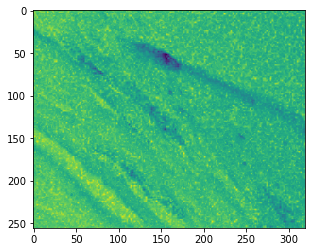

In [143]:
for path in tqdm(glob('/home/wellbeier/cdata/prepared/*/*')):
    augmented = np.load(path)
    plt.imshow(augmented[..., :3].max(-1))
    image = augmented[..., :3]
    mask = augmented[..., 3:]
    mask = mask[..., np.where(np.count_nonzero(mask, axis=(0, 1)))[0]] > 0

    additional = list()
    for channel in range(mask.shape[-1]):
        labels, colours = scipy.ndimage.label(mask[..., channel])
        for colour in range(2, colours):
            label = labels == colour
            if np.count_nonzero(label) > 5:
                mask[..., channel][label] = 0
                additional.append(np.expand_dims(label, -1))

    mask = np.dstack([mask] + additional)
    np.save(path[:-4], image)
    np.save(path[:-4] + 'mask', mask)

In [144]:
image = np.load(path)

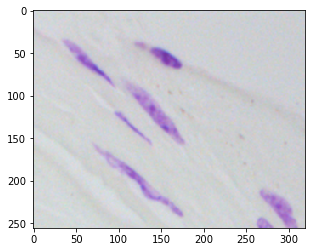

In [146]:
plt.imshow(image)

100%|██████████| 601/601 [17:32<00:00,  4.53it/s]


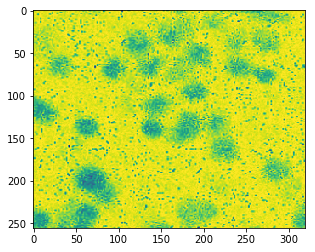

In [136]:
for path in tqdm(glob('/home/wellbeier/cdata/augmented/E2/*/*')):
    augmented = np.load(path)
    plt.imshow(augmented[..., :3].max(-1))
    image = augmented[..., :3]
    mask = augmented[..., 3:]
    mask = mask[..., np.where(np.count_nonzero(mask, axis=(0, 1)))[0]] > 0

    additional = list()
    for channel in range(mask.shape[-1]):
        labels, colours = scipy.ndimage.label(mask[..., channel])
        for colour in range(2, colours):
            label = labels == colour
            if np.count_nonzero(label) > 5:
                mask[..., channel][label] = 0
                additional.append(np.expand_dims(label, -1))

    mask = np.dstack([mask] + additional)
    np.save(path[:-4], image)
    np.save(path[:-4] + 'mask', mask)

In [85]:
photometric = iaa.SomeOf((0, 4),
    [
        iaa.OneOf([
            iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
            iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
            iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
        ]),
        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5), # add gaussian noise to images
        iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
        iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
        iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
        iaa.Multiply((0.5, 1.5), per_channel=False),
        iaa.ContrastNormalization((0.5, 1.), per_channel=0.5), # improve or worsen the contrast
    ],
    random_order=True
)

allowed_modes = ['constant', 'reflect', 'symmetric']
seq = iaa.Sequential(
    [
        iaa.WithChannels(
          channels=[0, 1, 2],
          children=photometric
        ),
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=allowed_modes,
            pad_cval=0
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.7, 1.3), "y": (0.7, 1.3)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[3], # use nearest neighbour or bilinear interpolation (fast)
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode=allowed_modes # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
    ], 
    random_order=True,
)

for type_id in ['0', '2']:
    for i in tqdm(range(200), total=200):
        path = np.random.choice(type_dict[type_id])
        img = scipy.misc.imread(
            os.path.join(
                DATA['TRAIN'],
                path,
                'images', 
                path + '.png'
            )
        )[..., :IMG_CHANNELS]
        masks = list()
        for mask_file in next(os.walk(os.path.join(DATA['TRAIN'], path) + '/masks/'))[2]:
            m_path = os.path.join(DATA['TRAIN'], path, 'masks', mask_file)
            masks.append(scipy.misc.imread(m_path))
        image = np.dstack([img, np.dstack(masks)])
        image_aug = seq.augment_images([image])[0]
        np.save(os.path.join(DATA['AUGMENTED'], type_id, path + '_' + str(i)), image_aug)


100%|██████████| 200/200 [03:04<00:00,  1.24it/s]


In [89]:
for type_id in [str(i) for i in range(7)]:
    for path in tqdm(type_dict[type_id], total=len(type_dict[type_id])):
        img = scipy.misc.imread(
            os.path.join(
                DATA['TRAIN'],
                path,
                'images', 
                path + '.png'
            )
        )[..., :IMG_CHANNELS]
        masks = list()
        for mask_file in next(os.walk(os.path.join(DATA['TRAIN'], path) + '/masks/'))[2]:
            m_path = os.path.join(DATA['TRAIN'], path, 'masks', mask_file)
            masks.append(scipy.misc.imread(m_path))
        image = np.dstack([img, np.dstack(masks)])
        np.save(os.path.join(DATA['PREPARED'], type_id, path + '_' + str(i)), image)

100%|██████████| 2/2 [00:00<00:00, 22.81it/s]


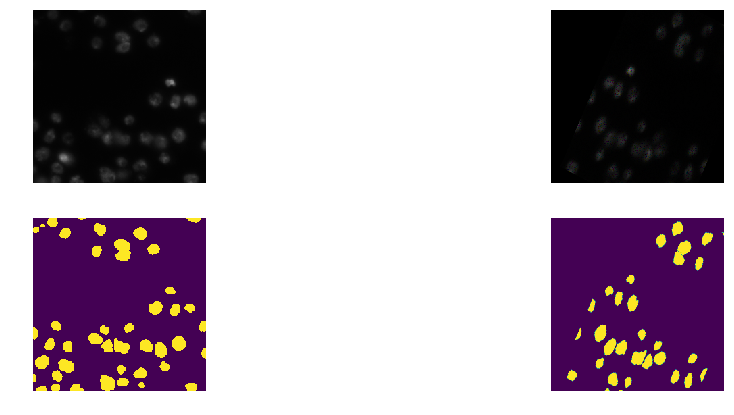

In [86]:
i = 0
plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.imshow(image[..., :3])
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(image_aug[..., :3])
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(image[..., 3:].max(-1))
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(image_aug[..., 3:].max(-1))
plt.axis('off')
plt.show()

In [ ]:
i = 6
plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.imshow(images[i][..., :3])
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(images_aug[i][..., :3])
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(images[i][..., 3:].max(-1))
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(images_aug[i][..., 3:].max(-1))
plt.axis('off')
plt.show()